In [108]:
# Import needed library
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Reshape, Flatten
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# Read in the Gold dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv", index_col='Date')

In [110]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
05/19/2023,"1,978.70","1,960.00","1,976.70","1,960.00",0.11K,1.13%
05/18/2023,"1,956.50","1,956.80","1,956.80","1,956.80",0.02K,-1.22%
05/17/2023,"1,980.70","1,983.60","1,983.60","1,983.60",0.01K,-0.39%
05/16/2023,"1,988.40","2,021.30","2,022.70","1,989.10",0.05K,-1.47%
05/15/2023,"2,018.00","2,013.80","2,017.10","2,013.80",0.00K,-0.09%
...,...,...,...,...,...,...
05/25/2018,"1,303.70","1,304.00","1,307.20","1,299.40",292.91K,-0.05%
05/24/2018,"1,304.40","1,293.30","1,306.40","1,292.20",432.42K,1.15%
05/23/2018,"1,289.60","1,290.60","1,298.40","1,286.70",402.34K,-0.19%



# Preprocessing Data

---

In [111]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

In [112]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# Split dataset (7-2-1)

---



In [113]:
# Split data
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [114]:
# Function create Dataset
import numpy
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [115]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [116]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [117]:
# Build the model
model = Sequential()

# Add an LSTM layer with 64 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=False))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_7-3.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

In [118]:
# Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 12s 351ms/step - loss: 0.1739 - val_loss: 0.0633
Epoch 2/100
13/13 [==============================] - 3s 246ms/step - loss: 0.0755 - val_loss: 0.0974
Epoch 3/100
13/13 [==============================] - 6s 472ms/step - loss: 0.0611 - val_loss: 0.0591
Epoch 4/100
13/13 [==============================] - 6s 425ms/step - loss: 0.0547 - val_loss: 0.0599
Epoch 5/100
13/13 [==============================] - 3s 246ms/step - loss: 0.0530 - val_loss: 0.0576
Epoch 6/100
13/13 [==============================] - 6s 448ms/step - loss: 0.0498 - val_loss: 0.0529
Epoch 7/100
13/13 [==============================] - 8s 625ms/step - loss: 0.0477 - val_loss: 0.0727
Epoch 8/100
13/13 [==============================] - 3s 262ms/step - loss: 0.0476 - val_loss: 0.0586
Epoch 9/100
13/13 [==============================] - 3s 251ms/step - loss: 0.0479 - val_loss: 0.0556
Epoch 10/100
13/13 [==============================] - 4s 305ms/step - loss: 0.0485 - val_l

In [119]:
# Predict test and validate
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 66ms/step


In [120]:
# Normalize the data
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [121]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)
  
  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [122]:
# Predict the next 30 days
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=70
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.8748646]
71
[0.8748646]
72
[0.8748646]
73
[0.8748646]
74
[0.8748646]
75
[0.8748646]
76
[0.8748646]
77
[0.8748646]
78
[0.8748646]
79
[0.8748646]
80
[0.8748646]
81
[0.8748646]
82
[0.8748646]
83
[0.8748646]
84
[0.8748646]
85
[0.8748646]
86
[0.8748646]
87
[0.8748646]
88
[0.8748646]
89
[0.8748646]
90
[0.8748646]
91
[0.8748646]
92
[0.8748646]
93
[0.8748646]
94
[0.8748646]
95
[0.8748646]
96
[0.8748646]
97
[0.8748646]
98
[0.8748646]
99
[0.8748646]
100


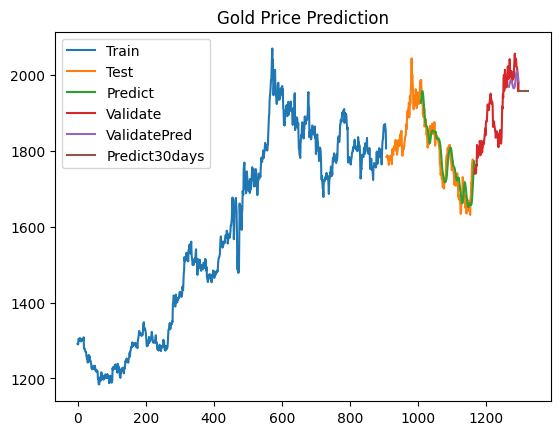

In [123]:
# Plot the predict
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title("Gold Price Prediction")
plt.show()

In [124]:
evaluateModel(ytest,y_pred,yval,y_pred_val)

** Testing **
MAE:  1774.5501083032534
MAPE:  273151.9200615775
RMSE:  1776.35443564535

** Validate **
MAE:  1982.3622233335982
MAPE:  213067.4385564999
RMSE:  1982.4132604635133


# Split dataset (6-3-1)

---



In [125]:
# 4. Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [126]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [127]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [128]:
# Build the model
model = Sequential()

# Add an LSTM layer with 64 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=False))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_7-3.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

In [129]:
# Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 11s 387ms/step - loss: 0.1757 - val_loss: 0.0948
Epoch 2/100
11/11 [==============================] - 3s 263ms/step - loss: 0.0715 - val_loss: 0.1059
Epoch 3/100
11/11 [==============================] - 4s 394ms/step - loss: 0.0615 - val_loss: 0.0861
Epoch 4/100
11/11 [==============================] - 3s 298ms/step - loss: 0.0564 - val_loss: 0.0544
Epoch 5/100
11/11 [==============================] - 3s 265ms/step - loss: 0.0543 - val_loss: 0.0548
Epoch 6/100
11/11 [==============================] - 3s 257ms/step - loss: 0.0510 - val_loss: 0.0572
Epoch 7/100
11/11 [==============================] - 3s 302ms/step - loss: 0.0485 - val_loss: 0.0494
Epoch 8/100
11/11 [==============================] - 4s 392ms/step - loss: 0.0475 - val_loss: 0.0533
Epoch 9/100
11/11 [==============================] - 3s 263ms/step - loss: 0.0466 - val_loss: 0.0576
Epoch 10/100
11/11 [==============================] - 3s 265ms/step - loss: 0.0469 - val_l

In [130]:
# Predict test and validate
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 93ms/step


In [131]:
# Normalize the data
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [132]:
# Predict the next 30 days
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=71
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.8689058]
72
[0.8689058]
73
[0.8689058]
74
[0.8689058]
75
[0.8689058]
76
[0.8689058]
77
[0.8689058]
78
[0.8689058]
79
[0.8689058]
80
[0.8689058]
81
[0.8689058]
82
[0.8689058]
83
[0.8689058]
84
[0.8689058]
85
[0.8689058]
86
[0.8689058]
87
[0.8689058]
88
[0.8689058]
89
[0.8689058]
90
[0.8689058]
91
[0.8689058]
92
[0.8689058]
93
[0.8689058]
94
[0.8689058]
95
[0.8689058]
96
[0.8689058]
97
[0.8689058]
98
[0.8689058]
99
[0.8689058]
100
[0.8689058]
101


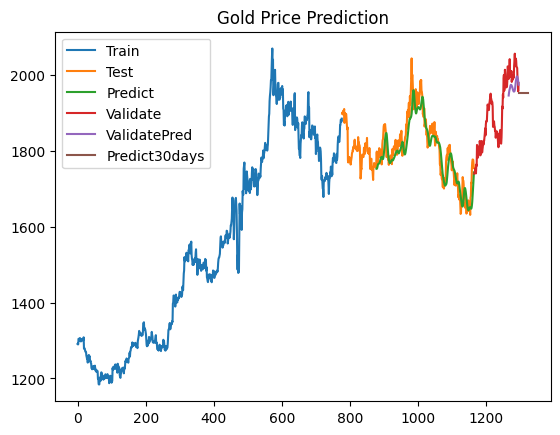

In [133]:
# Plot the predict
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title("Gold Price Prediction")
plt.show()

In [134]:
evaluateModel(ytest,y_pred,yval,y_pred_val)

** Testing **
MAE:  1791.9014603061187
MAPE:  260130.32486044223
RMSE:  1793.5419552621443

** Validate **
MAE:  1969.7596300498378
MAPE:  211677.67933263702
RMSE:  1969.8068848180596


# Split dataset (5-3-2)

---



In [135]:
# 4. Split data
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [136]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [137]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [138]:
# Build the model
model = Sequential()

# Add an LSTM layer with 64 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=False))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_7-3.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

In [139]:
# Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 11s 551ms/step - loss: 0.2453 - val_loss: 0.0663
Epoch 2/100
9/9 [==============================] - 2s 273ms/step - loss: 0.1065 - val_loss: 0.0767
Epoch 3/100
9/9 [==============================] - 2s 273ms/step - loss: 0.0750 - val_loss: 0.0573
Epoch 4/100
9/9 [==============================] - 3s 305ms/step - loss: 0.0596 - val_loss: 0.0592
Epoch 5/100
9/9 [==============================] - 4s 415ms/step - loss: 0.0545 - val_loss: 0.0627
Epoch 6/100
9/9 [==============================] - 3s 339ms/step - loss: 0.0479 - val_loss: 0.0485
Epoch 7/100
9/9 [==============================] - 3s 305ms/step - loss: 0.0480 - val_loss: 0.0511
Epoch 8/100
9/9 [==============================] - 2s 275ms/step - loss: 0.0463 - val_loss: 0.0463
Epoch 9/100
9/9 [==============================] - 2s 277ms/step - loss: 0.0449 - val_loss: 0.0653
Epoch 10/100
9/9 [==============================] - 3s 389ms/step - loss: 0.0455 - val_loss: 0.0443
Epoch 11

In [140]:
# Predict test and validate
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 51ms/step


In [141]:
# Normalize the data
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [142]:
# Predict the next 30 days
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=199
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.66320307 0.65382878 0.637452   0.65190874 0.65224757 0.66342896
 0.63903321 0.63892026 0.62378586 0.61237859 0.59329117 0.60831263
 0.60385137 0.59735713 0.59170996 0.61418568 0.60560199 0.61508923
 0.62864242 0.60243958 0.59306528 0.55714931 0.5641518  0.5581658
 0.55014683 0.55534222 0.56144116 0.53264061 0.5075672  0.51072961
 0.54890445 0.54732324 0.55116332 0.58504631 0.61723515 0.60627965
 0.60627965 0.59329117 0.5547775  0.56697538 0.5573752  0.55681048
 0.52507341 0.54212785 0.5328665  0.50847075 0.51140727 0.53343122
 0.53094646 0.53535125 0.5480009  0.54393494 0.52044274 0.51581206
 0.52597696 0.52631579 0.50474362 0.55635871 0.5607635  0.60085837
 0.59826067 0.64343799 0.66117009 0.66964084 0.6695279  0.66839846
 0.65394172 0.6442286  0.62751299 0.62785182 0.63428959 0.64377682
 0.64377682 0.62830359 0.65473232 0.65044048 0.71289813 0.7065733
 0.67461035 0.67585272 0.69347188 0.69742489 0.70781568 0.68703411
 0.72453129 0.71685114 0.68195166 0.69595663 0.69313

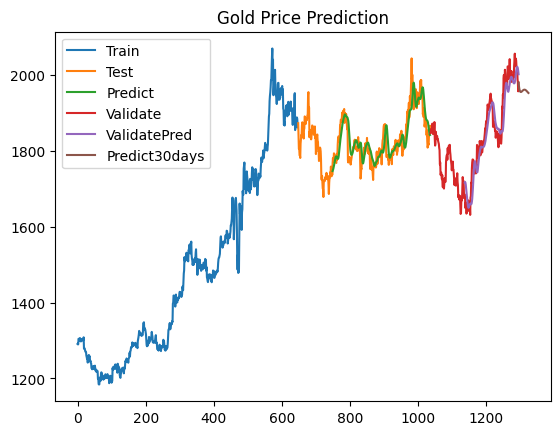

In [143]:
# Plot the predict
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title("Gold Price Prediction")
plt.show()

In [144]:
evaluateModel(ytest,y_pred,yval,y_pred_val)

** Testing **
MAE:  1835.2303727735764
MAPE:  252783.73640954983
RMSE:  1836.084538388214

** Validate **
MAE:  1851.1778484647932
MAPE:  249811.9374680131
RMSE:  1854.2674743957652


# Evaluate Model

---

